In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix

np.random.seed(412)  # For reproducibility
from scipy.sparse import csc_matrix, csr_matrix

In [2]:
# Install required packages in Jupyter Notebook
!pip install numpy scipy matplotlib scikit-learn


## Exercise 1)

In [3]:
#Loading data


def load_data(file_path):
    """Loads the data matrix X and target vector y from a CSV file"""
   
    # load data
    csv_data = pd.read_csv(file_path)
    print(f"Data features: \n {csv_data.columns.values} \n")

    # Separate features (X) and target (y)
    X = csv_data.iloc[:, :-1].values
    y = csv_data.iloc[:, -1].values

    print(y[2])

    num_ones_or_zeros_y=len(y[y == 0])+len(y[y==1])
    
    print(f"The # of ones and zeros: {num_ones_or_zeros_y} is the same as length of y {y.shape[0]}")


    # Convert y to ±1 (y is in {0, 1})
    y = np.where(y == 0, -1,1)

    return X, y


# Load the dataset
X, y = load_data('data.csv')
print(X.shape)

Data features: 
 ['android.permission.GET_ACCOUNTS'
 'com.sonyericsson.home.permission.BROADCAST_BADGE'
 'android.permission.READ_PROFILE' 'android.permission.MANAGE_ACCOUNTS'
 'android.permission.WRITE_SYNC_SETTINGS'
 'android.permission.READ_EXTERNAL_STORAGE'
 'android.permission.RECEIVE_SMS'
 'com.android.launcher.permission.READ_SETTINGS'
 'android.permission.WRITE_SETTINGS'
 'com.google.android.providers.gsf.permission.READ_GSERVICES'
 'android.permission.DOWNLOAD_WITHOUT_NOTIFICATION'
 'android.permission.GET_TASKS'
 'android.permission.WRITE_EXTERNAL_STORAGE'
 'android.permission.RECORD_AUDIO'
 'com.huawei.android.launcher.permission.CHANGE_BADGE'
 'com.oppo.launcher.permission.READ_SETTINGS'
 'android.permission.CHANGE_NETWORK_STATE'
 'com.android.launcher.permission.INSTALL_SHORTCUT'
 'android.permission.android.permission.READ_PHONE_STATE'
 'android.permission.CALL_PHONE' 'android.permission.WRITE_CONTACTS'
 'android.permission.READ_PHONE_STATE'
 'com.samsung.android.provider

In [4]:
# Display data details
print(f"Loaded dataset with {X.shape[0]} samples and {X.shape[1]} features.")
print(f"Number of malicious data points: {np.sum(y == 1)}")
print(f"Number of non-malicious data points: {np.sum(y == -1)}")

sparsity = len(X[X == 0]) / X.size * 100
print(f"{sparsity:.2f}% of X's entries are 0")


Loaded dataset with 29332 samples and 86 features.
Number of malicious data points: 14700
Number of non-malicious data points: 14632
89.01% of X's entries are 0


We dont need one hot encoding since all the data is binary. the data features and many others, are binary features. Each permission is either granted (1) or not granted (0).

## Exercise 2)

In [5]:
## Create test and training sets



def split_data(X, y, r=0.5):
    """
    Splits the data into training and test sets.
    X should be in CSC (Compressed Sparse Column) format.
    y will be returned as a dense vector.
    r: Test size ratio (0 < r < 1).
    """
    # Convert X to sparse CSC matrix (if not already sparse)
    if not isinstance(X, csc_matrix):
        X_sparse = csc_matrix(X)
    else:
        X_sparse = X
    
    # y is now expected to be a dense array, so no need to convert it to sparse
    y_dense = np.array(y)

    # Shuffle and split data
    indices = np.random.permutation(X_sparse.shape[0])
    split_index = int(X_sparse.shape[0] * (1 - r))

    # Splitting X
    X_train = X_sparse[indices[:split_index], :]
    X_test = X_sparse[indices[split_index:], :]
    
    # Splitting y (kept as dense)
    y_train = y_dense[indices[:split_index]]
    y_test = y_dense[indices[split_index:]]

    return X_train, X_test, y_train, y_test


# Split the dataset (50/50 split)
X_train, X_test, y_train, y_test = split_data(X, y, r=0.5)

## Exercise 3)

In [6]:
import numpy as np


def classify(X, y, w):
    """Returns the number of correctly classified points using the weight vector w."""
    # Perform matrix-vector multiplication (X.dot(w)) and predict using the sign function
    predictions = np.sign(X.dot(w))
    
    # Convert sparse vector y to dense for comparison
    if isinstance(y, np.ndarray):  # If y is already dense
        y_dense = y
    else:
        y_dense = y.toarray().flatten()  # Convert sparse matrix to dense and flatten it
    
    # Compare predictions with true labels and count correct classifications
    correct = np.sum(predictions == y_dense)
    accuracy = correct / len(y_dense)
    
    return correct, accuracy

# Example: Try random weight vector
w_random = np.random.randn(X_train.shape[1])  # Random weight vector of appropriate size
correct, accuracy = classify(X_test, y_test, w_random)
print(f"Random classification accuracy: {accuracy * 100:.2f}%")


Random classification accuracy: 69.68%


We can verify that the output makes sense for random weight vectors by calculating the mean over N trials:

In [7]:
avg_arr=[]
for i in range(0,100):
    w_random = np.random.randn(X_train.shape[1])  # Random weight vector of appropriate size
    correct,accuracy=classify(X_test,y_test,w_random)
    avg_arr.append(accuracy)


print(f"average accuracy is: {np.mean(avg_arr)}")
    

average accuracy is: 0.5088715396154371


As expected, we get a value around 50%

## Exercise 4

Let 
$$
X \in \mathbb{R}^{n \times d}
$$
be a data matrix, 
$$
\underline{\omega} \in \mathbb{R}^{d \times 1}
$$
be the parameter vector, and 
$$
\underline{y} \in \mathbb{R}^{n \times 1}
$$
be the vector of target labels.

Let $\sigma(z)$ denote the **sigmoid function**, defined as:
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

We define the following cost function for logistic regression with $L_2$ regularization:
$$
J(\underline{\omega}) = \sum_{i=1}^{n} L(y_i x_i^T \underline{\omega}) + \frac{\lambda}{2} \| \underline{\omega} \|^2
$$
where
$$
L(s) = \log(1 + e^{-s})
$$
is the logistic loss function.

### Gradient of the Logistic Regression Cost Function

Using the chain rule, we find the expression for the gradient of $J(\underline{\omega})$ with respect to $\omega_j$. The gradient of the cost function $J(\underline{\omega})$ with respect to $\underline{\omega}$ is given by:

$$
\frac{\partial J(\underline{\omega})}{\partial \omega_j} = \lambda \omega_j - \left(\sum_{i=1}^n \frac{\exp(-y_i x_i^T \underline{\omega})}{1 + \exp(-y_i x_i^T \underline{\omega})} y_i x_i^T \right) \underline{e_j}
$$

Let $z^T$ represent the row vector in the summation above:
$$
z^T = \sum_{i=1}^n \frac{\exp(-y_i x_i^T \underline{\omega})}{1 + \exp(-y_i x_i^T \underline{\omega})} y_i x_i^T
$$
Then, the gradient can be rewritten as:
$$
\nabla J(\underline{\omega}) = \lambda \underline{\omega} - \begin{bmatrix} z^T \underline{e_1} \\ z^T \underline{e_2} \\ \vdots \\ z^T \underline{e_d} \end{bmatrix} = \lambda \underline{\omega} - \begin{bmatrix} z_1 \\ z_2 \\ \vdots \\ z_d\end{bmatrix}=\lambda \underline{\omega} - \underline{z}
$$

By transposing $z^T$ to obtain $\underline{z}$, we get:
$$
\nabla J(\underline{\omega}) = \lambda \underline{\omega} - \sum_{i=1}^{n} \frac{\exp(-y_i x_i^T \underline{\omega})}{1 + \exp(-y_i x_i^T \underline{\omega})} y_i \underline{x_i}
$$

$$
\nabla J(\underline{\omega}) =\lambda \underline{\omega} - \sum_{i=1}^{n}  \frac{1}{1+\exp(y_i x_i^T \omega) } y_i \underline{x_i}
$$





Since $\frac{1}{1 + \exp(y_i x_i^T \underline{\omega})} = \sigma(-y_i x_i^T \underline{\omega})$, this simplifies to:
$$
\nabla J(\underline{\omega}) = \lambda \underline{\omega} - \sum_{i=1}^{n} \sigma(-y_i x_i^T \underline{\omega}) y_i \underline{x_i}
$$

Let $u_i = \sigma(-y_i x_i^T \underline{\omega}) y_i$, which essentially rescales $\underline{y}$ by the sigmoid function. Defining a new vector $\underline{u}$ with entries $u_i$, we can rewrite the gradient as:
$$
\nabla J(\underline{\omega}) = \lambda \underline{\omega} - \sum_{i=1}^{n} u_i \underline{x_i}
$$

Since $x_i^T$ represents a row of the matrix $X$, the vector $\underline{x_i}$ is, consequently, a column of the transposed matrix $X^T$. With this observation, we can see that the sum above simplifies to a matrix-vector product: 
$$
\nabla J(\underline{\omega}) = \lambda \underline{\omega} - X^T \underline{u}
$$

where the components of $\underline{u}$ are given by $u_i = \sigma(-y_i x_i^T \underline{\omega}) y_i$. 

## Exercise 5

In [8]:
import numpy as np
from scipy.special import expit  # Efficient sigmoid for sparse

def sigmoid(z):
    """Using Scipy's own Sigmoid function optimized for sparse matrices."""
    return expit(z)

def logistic_regression(X, y, alpha=0.001, reg_lambda=10, K=100):
    """
    Logistic regression using gradient descent with L2 regularization.
    Arguments:
    X -- sparse data matrix (CSC format)
    y -- labels
    alpha -- learning rate
    reg_lambda -- regularization constant
    K -- number of gradient descent steps
    
    Returns:
    w -- weight vector
    """
    # Initialize weights
    w = np.zeros(X.shape[1])
    
    # Gradient descent
    for step in range(K):
        # Prediction and gradient calculation
        scale_vector = sigmoid(-X.dot(w) * y)
        y_rescaled = scale_vector * y
        grad = -X.T.dot(y_rescaled) + reg_lambda * w
        # Update weights
        w -= alpha * grad
    
    return w


# Hyperparameters
alpha = 0.001
reg_lambda = 10
K = 100

# Train model
w = logistic_regression(X_train, y_train, alpha, reg_lambda, K)

# Evaluate on test set
correct, accuracy = classify(X_test, y_test, w)
print(f"Test set classification accuracy: {accuracy * 100:.2f}%")

# Calculate cost on training set
weights_vector = sigmoid(-X_train.dot(w) * y_train)
cost = -np.sum(np.log(weights_vector)) + 0.5 * reg_lambda * w.dot(w)
print(f"Cost: {cost / len(y_train):.4f}")


Test set classification accuracy: 94.86%
Cost: 5.1566


In [9]:
# Gathering Data to plot the accuracy of logistic gradient descent 
# for different values of reg_lambda and alpha
num_lambdas = 100
num_alphas = 100
reg_lambdas = np.linspace(1, 100, num_lambdas)
alphas = np.linspace(0.001, 0.01, num_alphas)

accuracies = np.zeros((num_lambdas, num_alphas))
for p1, reg_lambda in enumerate(reg_lambdas):
    for p2, alpha in enumerate(alphas):
        w = logistic_regression(X_train, y_train, alpha, reg_lambda, K)
        _, accuracies[p1, p2] = classify(X_test, y_test, w)

Text(0.5, 1.0, 'Accuracy for Different Regularization Lambda and Learning Rate Values')

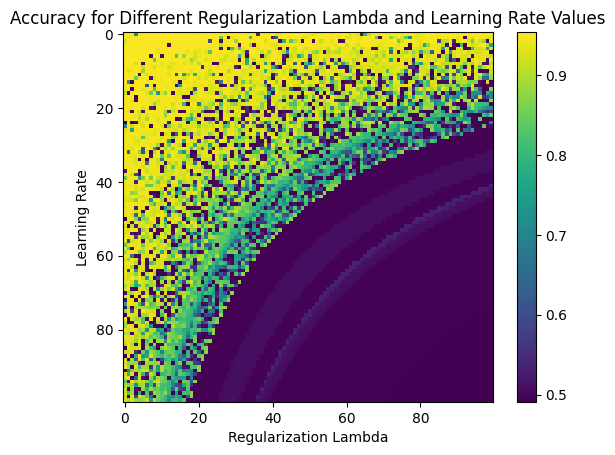

In [10]:
# Heatmap plot of accuracy
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.xlabel("Regularization Lambda")
plt.ylabel("Learning Rate")
plt.imshow(accuracies)
plt.colorbar()
plt.title("Accuracy for Different Regularization Lambda and Learning Rate Values")

### Exercise 6) 



In [11]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

# Load the dataset with fake points.
csv_data = pd.read_csv("data2.csv")
X = csv_data.iloc[:, :-1].values

# Use PCA with the number of PCA axes the same as our number of features.
# Additionaly whiten the data, meaning dividing each column by its standard deviation.
pca = PCA(whiten=True)
pca.fit(X)
X_pca = pca.transform(X)

# Affirming that each column has a standard deviation of 1.
epsilon = 0.01
assert np.all(np.abs(np.std(X_pca, axis=0) - 1) <= epsilon)

# Calculate the norm of points in the whitened PCA basis.
# Points with a large norm can be identified as potential outliers (refer to Lecture 8).
norm = np.linalg.norm(X_pca, axis=1) 

# Assuming we know that 2000 fake datapoints were added, 
# find the norm threshold that is less than exactly 2000 datapoints
sorted_norm = np.sort(norm)
threshold = sorted_norm[-2000]
print(threshold)
outliers = norm > threshold
# print(len(outliers[outliers==1]))

18.703055600592254


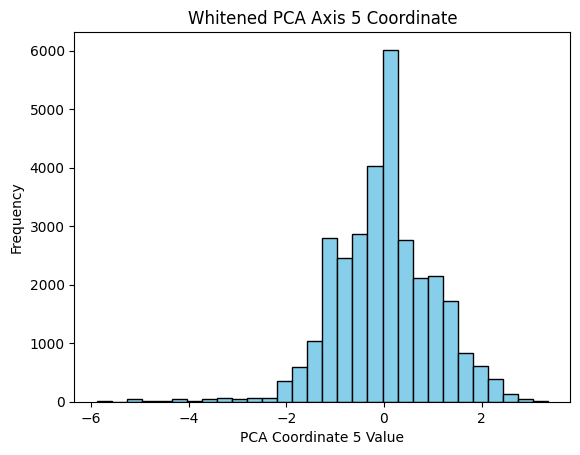

In [12]:
import matplotlib.pyplot as plt

# One assumption we made is that the PCA coordinates
# should be normally distributed and in fact we can see this is the case.
plt.hist(X_pca[:, 5], bins=30, color='skyblue', edgecolor='black')
plt.title('Whitened PCA Axis 5 Coordinate')
plt.xlabel('PCA Coordinate 5 Value')
plt.ylabel('Frequency')
plt.show()


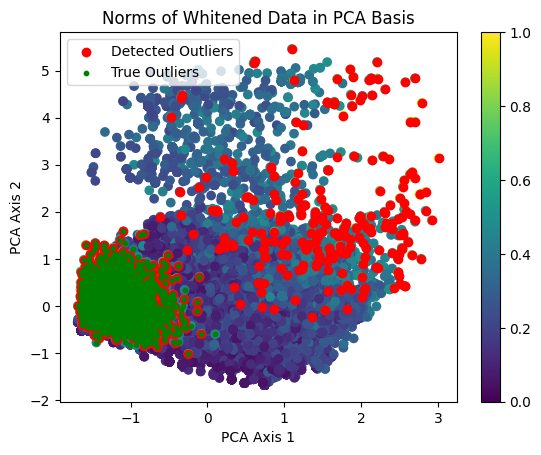

In [13]:
# This visualization shows the outlier points detected by thresholding the norms 
# of the whitened data, compared to the actual fake points that were added. 
# Most of the true fake points are clustered around (-1, 0) in the
# PCA-1 vs. PCA-2 coordinate space. We can also see that most of fake points were identified.
# Note: We found that the true outliers were the last 2000 points of X in data2.csv.

ax1 = 0
ax2 = 1
plt.scatter(X_pca[:,ax1], X_pca[:,ax2], c=norm)
plt.scatter(X_pca[outliers,ax1], X_pca[outliers,ax2], c="red", label="Detected Outliers")
plt.scatter(X_pca[-2000:,ax1], X_pca[-2000:,ax2],10, c="green", label="True Outliers")
plt.xlabel("PCA Axis 1")
plt.ylabel("PCA Axis 2")
plt.title("Norms of Whitened Data in PCA Basis")
plt.legend()
plt.colorbar()


In [14]:
# Fake points detected vs false positive statistics.

outlier_indices = np.array(np.where(outliers)).T
number_fake_detected = np.sum(outlier_indices > X.shape[0]-2000)
print(f"Number of fake points detected: {number_fake_detected}")
print(f"Number of real points falsely detected as fake: {2000 - number_fake_detected}")


Number of fake points detected: 1741
Number of real points falsely detected as fake: 259
